# Neural approaches

### Upload file on google colaboratory (from google drive)

Original article [there](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md)

In [0]:
id_url = "1qEYzNSo0EBhU0XfxputYvXxBFJ-CZ5OX" #Enter your id of google drive document

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':id_url})

In [0]:
output_file = 'down.root'
downloaded.GetContentFile(output_file)

## Data preparation

In [6]:
!pip install uproot -q #for colab

     |████████████████████████████████| 122kB 7.2MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 


In [0]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.patches import Ellipse, Circle

%matplotlib inline

In [0]:
info_tree = uproot.open(output_file)['info_sim']
raw_tree = uproot.open(output_file)['raw_data']

Распечатаю информацию о моделироании

In [9]:
info_tree.pandas.df(flatten=True).head(1)

,,events,momentum,theta,phi,zDis,layers,layers.first,layers.second,name,num_side_x,num_side_y,gap,size,chip_num_size,chip_pitch,chip_size,chip_offset,focal_length,trg_window,origin_pos._2,origin_pos._1,origin_pos._0
entry,subentry,,,,,,,,,,,,,,,,,,,,,,
0,0,50000,1000.0,0.0,1.570796,1.0,4,1.041,9.32,b'SensL_ARRAYJ-30020-64P-PCB_25V',8,17,1.0,26.68,8,0.2,3.16,0.0,200.0,20.0,201.0,106.72,0.0


Превращаю в таблицу данные моделирования

In [10]:
fulldf = raw_tree.pandas.df()
fulldf.head(3)

id_event  id_primary  ...  hits.phi.first  hits.phi.second
entry subentry                        ...                                 
0     0                1        -211  ...             0.0              0.0
      1                1        -211  ...             0.0              0.0
      2                1        -211  ...             0.0              0.0

[3 rows x 34 columns]

In [11]:
fulldf.describe()

,id_event,id_primary,pos_primary._2,pos_primary._1,pos_primary._0,dir_primary._2,dir_primary._1,dir_primary._0,hits,hits.id_pmt,hits.id_chip,hits.id_layer,hits.id_track,hits.id_track_parent,hits.id_hit,hits.wavelength,hits.time,hits.pos_exact._2,hits.pos_exact._1,hits.pos_exact._0,hits.pos_chip._2,hits.pos_chip._1,hits.pos_chip._0,hits.pos_vertex._2,hits.pos_vertex._1,hits.pos_vertex._0,hits.dir_vertex._2,hits.dir_vertex._1,hits.dir_vertex._0,hits.theta.first,hits.theta.second,hits.phi.first,hits.phi.second
count,993407.000000,993407.000000,993407.0,993407.000000,993407.000000,993407.0,993407.0,993407.0,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.0,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,9.934070e+05,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.0,993407.0,993407.0,993407.0
mean,25035.193149,-211.588530,0.0,0.004829,-0.006412,1.0,0.0,0.0,40.765470,64.782044,32.552517,2.747392,245.442823,2.550117,0.0,427.671705,0.716711,201.000570,3.791223,0.015351,2.010500e+02,3.792310,0.015192,21.247246,0.011625,-0.004948,0.963746,0.002538,0.000148,0.0,0.0,0.0,0.0
std,14414.621555,8.024464,0.0,0.969555,0.969505,0.0,0.0,0.0,7.795391,23.256084,17.668222,1.101370,133.685231,19.852174,0.0,108.187371,0.087131,0.006132,47.696520,39.296890,2.496166e-09,47.718007,39.318050,9.932300,1.279194,1.160645,0.021641,0.187929,0.188154,0.0,0.0,0.0,0.0
min,1.000000,-321.000000,0.0,-1.679763,-1.679778,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.0,200.049021,0.671925,201.000000,-128.059814,-110.216036,2.010500e+02,-126.480000,-108.640000,1.000155,-93.654610,-84.189243,-0.983523,-0.999515,-0.998301,0.0,0.0,0.0,0.0
25%,12664.000000,-211.000000,0.0,-0.827906,-0.845975,1.0,0.0,0.0,36.000000,40.000000,17.000000,2.000000,137.000000,1.000000,0.0,348.774747,0.696598,201.000000,-35.261286,-37.159636,2.010500e+02,-36.720000,-36.480000,13.241316,-0.835164,-0.851899,0.962136,-0.179502,-0.187729,0.0,0.0,0.0,0.0
50%,24856.000000,-211.000000,0.0,-0.000010,-0.015476,1.0,0.0,0.0,40.000000,68.000000,33.000000,3.000000,253.000000,1.000000,0.0,410.311039,0.697337,201.000000,1.651972,-0.505239,2.010500e+02,1.040000,-2.080000,22.538553,0.001009,-0.014494,0.964887,0.002793,0.000080,0.0,0.0,0.0,0.0
75%,37516.000000,-211.000000,0.0,0.842198,0.831608,1.0,0.0,0.0,45.000000,89.000000,48.000000,4.000000,353.000000,1.000000,0.0,483.119867,0.698236,201.000000,38.443551,37.230225,2.010500e+02,39.600000,36.480000,29.958778,0.851051,0.839157,0.967844,0.183594,0.188108,0.0,0.0,0.0,0.0
max,50000.000000,-211.000000,0.0,1.679900,1.679988,1.0,0.0,0.0,113.000000,136.000000,64.000000,4.000000,4301.000000,2625.000000,0.0,899.990047,3.009657,201.099998,341.430033,110.218249,2.010500e+02,339.920000,108.640000,35.999992,93.090047,80.333879,0.999997,0.998824,0.991826,0.0,0.0,0.0,0.0


In [0]:
df = raw_tree.pandas.df(branches=['hits.pos_chip._0', 'hits.pos_chip._1', 'hits.pos_vertex._0', 'hits.pos_vertex._1'])
df = df.rename({'hits.pos_chip._0':'chip_x', 'hits.pos_chip._1':'chip_y', 'hits.pos_vertex._0':'vertex_x', 'hits.pos_vertex._1':'vertex_y'}, axis=1)

In [0]:
data = df.groupby('entry').agg({'chip_x': list, 'chip_y': list, 'vertex_x': 'mean', 'vertex_y': 'mean'})

In [14]:
data.head()

,chip_x,chip_y,vertex_x,vertex_y
entry,,,,
0,"[-98.55999999999999, -36.47999999999999, -36.4...","[-67.75999999999999, -33.36000000000001, -33.3...",1.609652,1.125650
2,"[-85.11999999999999, -85.11999999999999, -57.4...","[129.35999999999999, 205.67999999999995, 118.4...",0.241547,0.048154
3,"[-33.11999999999999, -36.47999999999999, -43.1...","[-40.080000000000005, -30.000000000000007, -23...",1.526540,0.478399
4,"[-91.83999999999999, -85.11999999999999, -77.6...","[-85.35999999999999, 74.0, -30.000000000000007...",1.102120,-1.260826
8,"[-33.11999999999999, -39.839999999999996, -49....","[-40.080000000000005, -30.000000000000007, -19...",0.040140,-0.860000


Теперь у меня подготовленные данные. Разобью таблицу на `train` и `test` части. Финальный результат буду формировать по результатам на `test`. Так можно будет сравнивать подходы

In [0]:
from sklearn.model_selection import train_test_split
X = data[['chip_x', 'chip_y']]
y = data[['vertex_x', 'vertex_y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Пример события

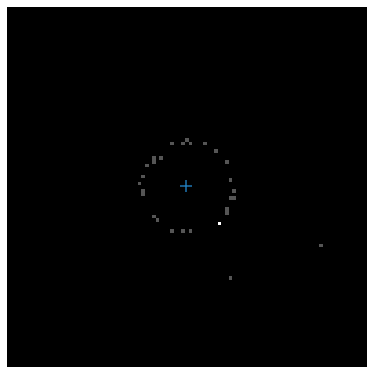

In [16]:
loc_ind = 15940 # 21
x = data['chip_x'].loc[loc_ind]
y = data['chip_y'].loc[loc_ind]
xv = data['vertex_x'].loc[loc_ind]
yv = data['vertex_y'].loc[loc_ind]
xedges = np.linspace(-200, 200, 100)
yedges = np.linspace(-200, 200, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

fig = plt.figure(frameon=False, figsize=(5, 5) )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H, cmap='gray')
plt.scatter(xv, yv, marker='+', s=150) #mean vertex
# fig.savefig('data.png', dpi=40) #real figure size = figsize*dpi

## Подходы

### FitEllipse
____
фитирование эллипса методом наименьших квадратов

дополнительно используется `hit-or-miss` фильтр, чтоб избежать негативного воздействия шумов на фит эллипса

In [0]:
def hit_or_miss_cleaner(img, kernel_size=9):
    kernel = (np.zeros((kernel_size,kernel_size))-1).astype('int')
    c = (kernel_size-1)//2
    kernel[c, c] = 1
    dst = cv2.morphologyEx(img, cv2.MORPH_HITMISS, kernel)
    dst = cv2.bitwise_not(dst)
    dst = cv2.bitwise_and(img, dst)
    return dst

def ellipse_finder(img, kernel_size):
    dst = hit_or_miss_cleaner(img, kernel_size)
    nzs= cv2.findNonZero(dst)
    try:
        ellipse = cv2.fitEllipse(nzs)
        ellipse = ( [ellipse[0][0]-len(img)//2, ellipse[0][1]-len(img)//2], [ellipse[1][0]*4, ellipse[1][1]*4], ellipse[2] ) 
    except:
        ellipse = ( [0, 0], [0, 0], 0)
    return ellipse, dst

def show_picture(ellipse, img, xedges, yedges, ax):
    X, Y = np.meshgrid(xedges, yedges)

    ax.set_axis_off()
    ax.pcolormesh(X, Y, img, cmap='gray')
    e = Ellipse(xy=(ellipse[0][0], ellipse[0][1]), width=ellipse[1][0], height=ellipse[1][1],\
                angle=ellipse[2], linewidth=2, fill=False, edgecolor='green', alpha=0.5)
    ax.add_artist(e)
    return

def get_image_from_row(loc_ind, X):
    x = X['chip_x'].iloc[loc_ind]
    y = X['chip_y'].iloc[loc_ind]
    xedges = np.linspace(-200, 200, 100)
    yedges = np.linspace(-200, 200, 100)
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    img = (np.where(H>0, 255, 0)).astype(np.uint8)
    return (img, xedges, yedges)

def full_finder(loc_ind, X, kernel_size=20, return_images=True):
    img, xedges, yedges = get_image_from_row(loc_ind, X)
    ellipse, dst = ellipse_finder(img, kernel_size)
    return (ellipse, [img, dst, xedges, yedges]) if return_images else ellipse

#### Пример

Left image: **original**, 

Right image: **filtered**

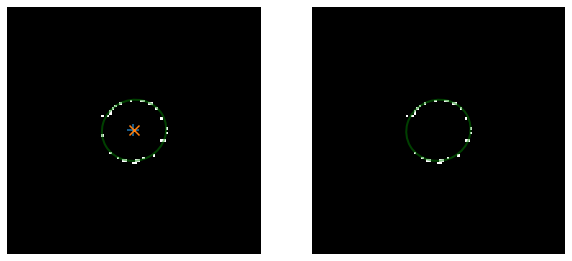

In [18]:
index = 52

ellipse, imgs = full_finder(index, X_train, 9, return_images=True)
fig = plt.figure(frameon=False, figsize=(10, 10) )
ax = plt.subplot(221)
show_picture(ellipse, imgs[0], imgs[2], imgs[3], ax)
ax.scatter(y_train['vertex_x'].iloc[index], y_train['vertex_y'].iloc[index], marker='+', s=150) #mean vertex
ax.scatter(ellipse[0][0], ellipse[0][1], marker='x', s=100) #mean vertex
ax2 = plt.subplot(222)
show_picture(ellipse, imgs[1], imgs[2], imgs[3], ax2)

#### Теперь получу параметры эллипсов и возьму лучшие записи эллипсов для обучения нейросети

In [0]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [0]:
y_pred = pd.DataFrame( np.array( [ full_finder(i, X, 9, False) for i in range(len(y)) ] ), columns=['cen_pred', 'rad_pred', 'ang_pred'] )
y_pred['x_pred'], y_pred['y_pred'] = np.array( y_pred['cen_pred'].tolist() ).T
y_pred['radius_pred'] = np.array(y_pred['rad_pred'].tolist()).mean(axis=1)
y_pred.drop(['cen_pred', 'rad_pred', 'ang_pred'], axis=1, inplace=True)

In [0]:
result_table = pd.concat([y_pred, y], axis=1)

In [37]:
result_table.head()

,x_pred,y_pred,radius_pred,vertex_x,vertex_y
0,1.554207,-0.718327,112.937634,1.609652,1.125650
1,0.068363,-0.021889,101.519123,0.241547,0.048154
2,-0.249451,0.143044,102.022346,1.526540,0.478399
3,-0.534019,0.300720,100.633137,1.102120,-1.260826
4,-0.430103,0.026142,100.728416,0.040140,-0.860000


In [0]:
r = result_table
r['distance'] = np.sqrt( (r['x_pred']-r['vertex_x'])**2 + (r['y_pred']-r['vertex_y'])**2 )

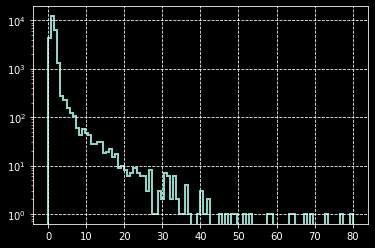

In [39]:
plt.style.use('dark_background')
plt.hist(r.distance, histtype='step', bins=100, range=(0, 80), lw=2);
plt.grid(linestyle='--')
plt.yscale('log')

**Результат**

In [0]:
y_new = r.query('distance<3')[['vertex_x', 'vertex_y', 'radius_pred']].copy()
X_new = X.loc[y_new.index].copy()

Теперь этап написания нейронной сети

По аналогии с [примером](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [140]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear( 16 * 6 * 6, 120)
        # self.fc2 = nn.Linear( 120, 84)
        self.fc3 = nn.Linear( 120, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=3, bias=True)
)


In [141]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

8
torch.Size([6, 1, 3, 3])


In [0]:
hists = []
for x,y in zip(X_new.chip_x.values, X_new.chip_y.values):
    h, _, _ = np.histogram2d(x,y, bins=np.linspace(-100, 100, 33))
    hists.append( [h] ) #np.ravel(h) )
X_hists = np.array(hists)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_hists, y_new, random_state=42)

In [0]:
input = torch.Tensor(X_train)

In [190]:
# defining the model
model = net
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=3, bias=True)
)


In [0]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_tr, y_tr = Variable(torch.Tensor(X_train)), Variable( torch.Tensor( y_train[['radius_pred', 'vertex_x', 'vertex_y']].values ) )
    # getting the validation set
    x_val, y_val = Variable(torch.Tensor(X_test[:100])), Variable( torch.Tensor( y_test[['radius_pred', 'vertex_x', 'vertex_y']].values[:100] ) )
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_tr = x_tr.cuda()
        y_tr = y_tr.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_tr)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_tr)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_train.cpu().detach().numpy(), '| Val loss :', loss_val.cpu().detach().numpy())

In [234]:
# defining the number of epochs
n_epochs = 100
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : 41.94025 | Val loss : 135.38359
Epoch :  3 	 loss : 41.747154 | Val loss : 135.38333
Epoch :  5 	 loss : 41.563217 | Val loss : 135.388
Epoch :  7 	 loss : 41.38805 | Val loss : 135.39726
Epoch :  9 	 loss : 41.221275 | Val loss : 135.41084


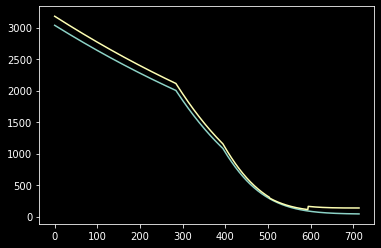

In [235]:
plt.plot(train_losses)
plt.plot(val_losses)

In [0]:
nn_result = model(torch.Tensor(X_test).cuda()).cpu().data.numpy()

In [0]:
_, X_test, _, y_test = train_test_split(X_new, y_new, random_state=42)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [0]:
y_pred = pd.DataFrame(nn_result, columns=['rad_pred', 'x_pred', 'y_pred'])

In [0]:
result = pd.concat([X_test, y_test, y_pred], axis=1)

In [0]:
loc_ind = 15940 # 21
x = data['chip_x'].loc[loc_ind]
y = data['chip_y'].loc[loc_ind]
xv = data['vertex_x'].loc[loc_ind]
yv = data['vertex_y'].loc[loc_ind]
xedges = np.linspace(-200, 200, 100)
yedges = np.linspace(-200, 200, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

fig = plt.figure(frameon=False, figsize=(5, 5) )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H, cmap='gray')
plt.scatter(xv, yv, marker='+', s=150) #mean vertex
# fig.savefig('data.png', dpi=40) #real figure size = figsize*dpi